# Response Surface Methodology (RSM)

- designed to optimize continuous parameters


## Optimize a single continuous parameter

In [1]:
import numpy as np

In [2]:
def markout_profit(threshold):
    cost = 1
    pps = 1
    signal = np.random.normal()
    eps = 2 * np.random.normal()
    if signal > threshold or signal < -threshold:
        profit = pps * np.abs(signal) - cost + eps
    else:
        profit = 0
    return profit

In [3]:
np.random.seed(17)
([markout_profit(0.15) for _ in range(10)], [markout_profit(0.5) for _ in range(10)])

([-4.432990267591691,
  1.9145236904705367,
  3.8104683277910985,
  0,
  0,
  3.475877498753951,
  0.5427136576035457,
  -4.010724960358923,
  -0.6320195582677376,
  -0.4078249827483169],
 [2.0448324885405436,
  0,
  0.06889559859304795,
  0.5325419453659244,
  0.455015020479104,
  -0.29962873534988227,
  0,
  1.7074529797072233,
  0.4983477757546042,
  -3.90661649896564])

In [4]:
def run_experiment(num_ind, thresholds):
    individual_measurements = {threshold: [] for threshold in thresholds}
    done = set()
    while True:
        threshold = np.random.choice(thresholds)
        profit = markout_profit(threshold)
        individual_measurements[threshold].append(profit)
        if len(individual_measurements[threshold]) >= num_ind:
            done.add(threshold)
        if len(done) == len(thresholds):
            break

    aggregate_measurements = []
    standard_errors = []
    for threshold in thresholds:
        ims = np.array(individual_measurements[threshold])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))

    return (
        aggregate_measurements,
        standard_errors,
    )

In [5]:
np.random.seed(17)
thresholds = np.array([0.5, 1.0, 1.5])
aggregate_measurements, standard_errors = run_experiment(15_000, thresholds)

In [6]:
aggregate_measurements, standard_errors

([0.09848496576216006, 0.1711214205711533, 0.13699263220703944],
 [0.013267765976681866, 0.00957041724519083, 0.006796544642991194])

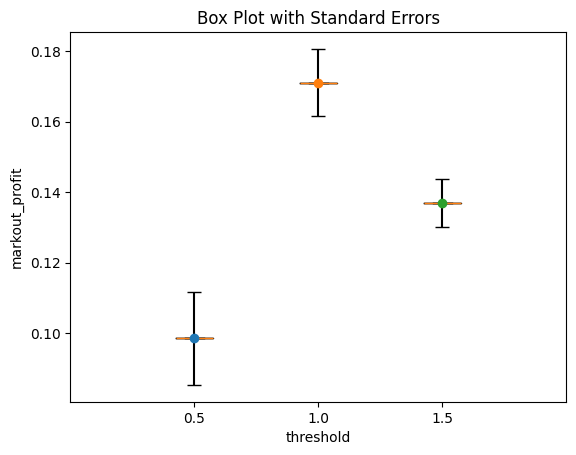

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def boxplot(data, std_err, positions):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot violin plot
    ax.boxplot(data, positions=positions)

    # Add standard error bars
    for i, (x, y, serr) in enumerate(zip(positions, data.flatten(), std_err)):
        ax.errorbar(x, y, yerr=serr, fmt="o", capsize=5, ecolor="black")

    # Set title and labels
    ax.set_title("Box Plot with Standard Errors")
    ax.set_xlabel("threshold")
    ax.set_ylabel("markout_profit")
    return ax


# Sample data
# For boxplot, every group should be an array of measurements,
# that is why we reshape the 1d array of aggregate measurements.
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = thresholds
boxplot(data, std_err, positions);

In [8]:
# The function performs a polynomial regression,
# specifically fitting a quadratic model to the given data.
# The returned beta array contains the coefficients of the fitted polynomial,
# allowing you to predict y values given new x values using the model:
def linear_regression(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [9]:
beta = linear_regression(thresholds, aggregate_measurements)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [10]:
# Alternative approach using np.linalg.solve, which may be better than doing the np.linalg.inv
def solve(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    return np.linalg.solve(X, y)


solve(thresholds, aggregate_measurements)

array([-0.08091673,  0.46556864, -0.21353049])

In [11]:
# Calculate the predicted y values using the beta coefficients
def interpolate(thresholds, beta):
    xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
    XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
    yhat = XHat @ beta
    return xhat, yhat

In [12]:
def optimize(thresholds, beta):
    xhat, yhat = interpolate(thresholds, beta)
    i = np.where(yhat == yhat.max())[0][0]
    return xhat[i], yhat[i]

In [13]:
beta = linear_regression(thresholds, aggregate_measurements)
threshold_opt, estimated_max_profit = optimize(thresholds, beta)
threshold_opt, estimated_max_profit

(1.0900000000000005, 0.17285751361179258)

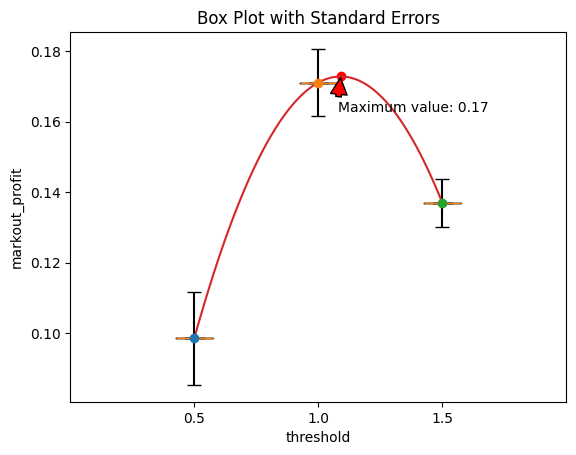

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors

ax = boxplot(data, std_err, thresholds)

xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
yhat = XHat @ beta

ax.plot(xhat, yhat)

max_x = threshold_opt
max_y = estimated_max_profit
# Annotate the maximum point
plt.annotate(
    f"Maximum value: {max_y:.2f}",
    xy=(max_x, max_y),
    xytext=(max_x - 0.01, max_y - 0.01),
    arrowprops=dict(facecolor="red", shrink=0.05),
)

# Alternatively, we can just use scatter to indicate the maximum point.
plt.scatter(max_x, max_y, color="red", marker="o")


# Show plot
plt.show()

In [15]:
np.random.seed(17)
aggregate_measurement, standard_error = run_experiment(15_000, [threshold_opt])
(
    aggregate_measurement[0] - 2 * standard_error[0],
    aggregate_measurement[0] + 2 * standard_error[0],
)

(0.14048962175141153, 0.17627270610659548)

## Optimizing two or more continuous parameters

In [16]:
def markout_profit_2D(threshold, order_size):
    cost = 1
    pps = 1  # Profit per signal

    # Adverse selection cost.
    asc = 0.001 * np.exp(2 * order_size)
    signal = np.random.normal()
    eps = 2 * np.random.normal()

    # Buy when signal is strong positive,
    # sell when the signal is strong negative.
    if signal > threshold or signal < -threshold:
        # Profit is offset by adverse selection.
        profit = order_size * (pps * np.abs(signal) - cost + eps) - asc
    else:
        # There is no profit if we don't trade.
        profit = 0
    return profit

In [17]:
# Face-centered central composite design
def design_ccd(thresholds, order_sizes):
    parameters = [
        (threshold, order_size)
        for threshold in thresholds
        for order_size in order_sizes
    ]
    return parameters

In [18]:
parameters = design_ccd(thresholds=[0.5, 1.0, 1.5], order_sizes=[1, 1.5, 2])
parameters

[(0.5, 1),
 (0.5, 1.5),
 (0.5, 2),
 (1.0, 1),
 (1.0, 1.5),
 (1.0, 2),
 (1.5, 1),
 (1.5, 1.5),
 (1.5, 2)]

In [19]:
import random


def run_experiment_2D(num_ind, parameters):
    individual_measurements = {parameter: [] for parameter in parameters}
    done = set()
    while True:
        parameter = random.choice(parameters)
        threshold, order_size = parameter
        profit = markout_profit_2D(threshold, order_size)
        individual_measurements[parameter].append(profit)
        if len(individual_measurements[parameter]) >= num_ind:
            done.add(parameter)
        if len(done) == len(individual_measurements):
            break

    aggregate_measurements = []
    standard_errors = []
    for parameter in parameters:
        ims = np.array(individual_measurements[parameter])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))

    return aggregate_measurements, standard_errors

In [20]:
np.random.seed(17)
# parameters = design_ccd(thresholds=[1, 1.5, 2], order_sizes=[1, 1.5, 2])
# parameters = design_ccd(thresholds=[0.5, 1, 1.5], order_sizes=[2.5, 3.0, 3.5])
parameters = design_ccd(thresholds=[0.75, 1, 1.25], order_sizes=[2.75, 3.0, 3.25])

aggregate_measurements, standard_errors = run_experiment_2D(15_000, parameters)
aggregate_measurements, standard_errors

([0.2646522965756872,
  0.2454920045765666,
  0.19432013312827526,
  0.3761781365054332,
  0.31039511099010236,
  0.34940454762815315,
  0.3738789707238803,
  0.40564396103898587,
  0.37488031410441824],
 [0.030713502374250433,
  0.03417908366197812,
  0.036595002156779646,
  0.026212905949839858,
  0.028165337042961168,
  0.03051688662644697,
  0.021489191388520408,
  0.02341628044405465,
  0.0259962939157378])

<Axes: title={'center': 'Box Plot with Standard Errors'}, xlabel='threshold', ylabel='markout_profit'>

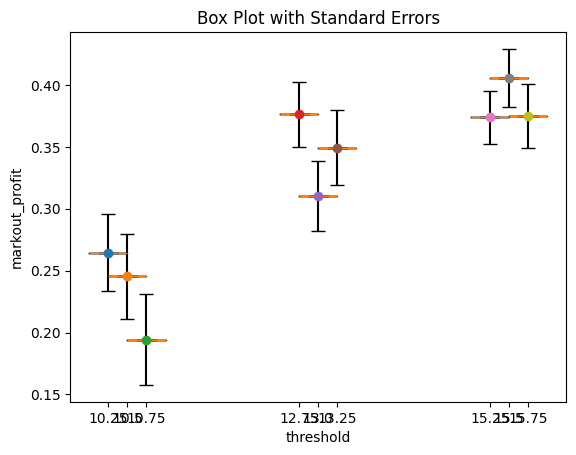

In [21]:
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = [i[0] * 10 + i[1] for i in parameters]
boxplot(data, std_err, positions)

### Linear regression for two parameters

In [22]:
def linear_regression_2D(parameters, aggregate_measurements):
    parameters = np.array(parameters)
    x0 = parameters[:, 0]
    x1 = parameters[:, 1]
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x0, x1, x0**2, x1**2, x0 * x1]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [23]:
beta = linear_regression_2D(parameters, aggregate_measurements)
beta

array([ 0.77025795,  0.58042598, -0.51343956, -0.56823443,  0.02733932,
        0.28533403])

In [24]:
def interpolate_2D(parameters, beta):
    parameters = np.array(parameters)
    x0_values = np.arange(parameters[:, 0].min(), parameters[:, 0].max() + 1e-6, 0.01)
    x1_values = np.arange(parameters[:, 1].min(), parameters[:, 1].max() + 1e-6, 0.01)
    x0hat_2d, x1hat_2d = np.meshgrid(x0_values, x1_values)
    x0hat = x0hat_2d.flatten()
    x1hat = x1hat_2d.flatten()
    XHat = np.array(
        [np.ones(len(x0hat)), x0hat, x1hat, x0hat**2, x1hat**2, x0hat * x1hat]
    ).T
    yhat = XHat @ beta
    yhat_2d = np.reshape(yhat, (len(x1_values), len(x0_values)))
    return x0hat_2d, x1hat_2d, yhat_2d

In [25]:
def optimize_2D(parameters, beta):
    x0hat, x1hat, yhat = interpolate_2D(parameters, beta)
    i = np.where(yhat == yhat.max())
    return x0hat[i][0], x1hat[i][0], yhat[i][0]

In [26]:
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2D(parameters, beta)
threshold_opt, order_size_opt, estimated_max_profit

(1.2500000000000004, 3.2499999999999893, 0.3871866263670021)

In [27]:
x0hat, x1hat, yhat = interpolate_2D(parameters, beta)

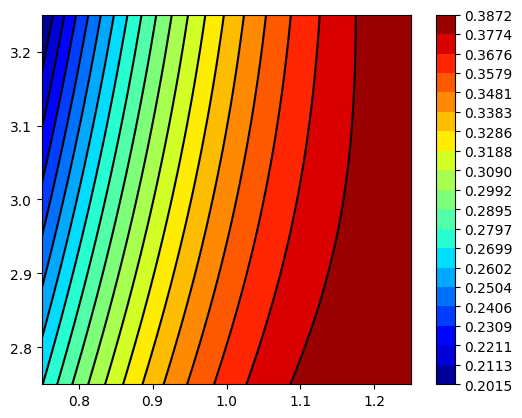

In [28]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# http://en.wikipedia.org/wiki/File:Bilininterp.png
xi = x0hat
yi = x1hat
zi = yhat


# I want 20 "levels" to be shown
contour_breaks = 20
ticks = np.linspace(zi.min(), zi.max(), contour_breaks, endpoint=True)

fig = plt.figure()
axes = fig.add_subplot(111, aspect="equal")
axes.contour(xi, yi, zi, ticks[1:-1], colors="k")
fill = axes.contourf(xi, yi, zi, ticks, cmap=cm.jet)
fig.colorbar(fill, ticks=ticks)

# Show the plots
plt.show()

<Axes: title={'center': 'Box Plot with Standard Errors'}, xlabel='threshold', ylabel='markout_profit'>

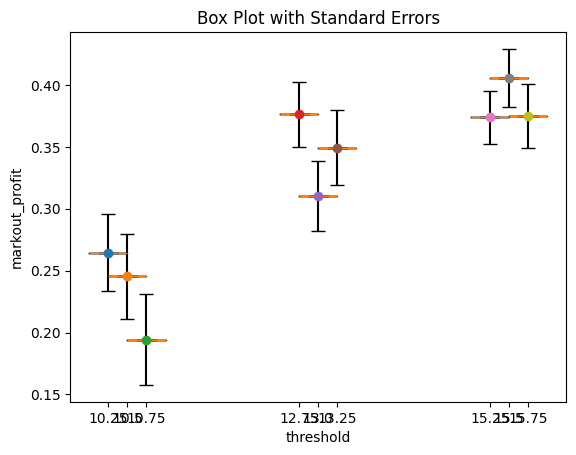

In [29]:
data = np.array(aggregate_measurements).reshape(1, -1)
std_err = standard_errors
positions = [i[0] * 10 + i[1] for i in parameters]
boxplot(data, std_err, positions)

In [30]:
aggregate_measurements, standard_error = run_experiment_2D(
    15_000, parameters=[(threshold_opt, order_size_opt)]
)
aggregate_measurements, standard_error

([0.3445779268266859], [0.02499982727088869])

In [31]:
(
    aggregate_measurement[0] - 2 * standard_error[0],
    aggregate_measurement[0] + 2 * standard_error[0],
)

(0.10838150938722613, 0.20838081847078088)